##### 1) Import and Data Loading

In [9]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")
import itertools
import collections
import re
import nltk
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk import bigrams, trigrams
import gensim
from gensim import corpora


from pprint import pprint

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 50000000)
pd.set_option('display.max_columns', 50000000)
pd.options.display.max_colwidth = 1000000000
pd.set_option('display.width', 1000000)
pd.options.display.float_format = '{:.2f}'.format

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91916\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91916\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91916\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
## Importing models
from sklearn.model_selection import train_test_split as tts, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
from mlxtend.classifier import StackingCVClassifier
from imblearn.over_sampling import SMOTE

In [11]:
train_data = pd.read_csv("train.csv")
train_data.head()

tweet_id                                                                                                                                            tweet  sentiment
0      1701                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller          1
1      1851  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw          1
2      2689             one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}          2
3      4525                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork          0
4      3604                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}          1

In [12]:
train_data.tail()

tweet_id                                                                                                                                         tweet  sentiment
7269      3343                                                 @mention Google plze Tammi.  I'm in middle of #SXSW craziness and everything is soooooo busy!          1
7270      5334                                                   RT @mention ÷¼ Are you all set? ÷_ {link} ÷_ #edchat #musedchat #sxsw #sxswi #newTwitter          1
7271      5378  RT @mention Aha! Found proof of lactation room, excuse me, &quot;Mother's Room,&quot; brought to you by Google, at last year's #SXSW. {link}          1
7272      2173                                                  We just launched our iPad app at #SXSW! Get all the details + the first edition FREE: {link}          1
7273      3162     The next fin serv battle is vs Apple, GOOG, Mobile operators. They have consumer loyalty and tons of cash (vs. Banks) #bankinnovate #SXSW          1

In [13]:
test_data = pd.read_csv("test.csv")
test_data.tail()

tweet_id                                                                                                                        tweet
1814      1550                           @mention @mention @mention Hmmm....how fast can #apple build a new store in time for #sxsw  {link}
1815      1933                                          Samsung Galaxy S II Appears At FCC And Team Android #SXSW Party {link} via @mention
1816      9052                                          @mention You could buy a new iPad 2 tmrw at the Apple pop-up store at #sxsw: {link}
1817      4219          Wow very long queue of people at apple pop up store now, some have bought 3 iPads! #sxsw@mention Room#NokiaConnects
1818      7210  Privacy Could Headline Google Circles Social Network Reveal Later Today [Social Networks] {link} #ACLU #GoogleCircles #SXSW

In [14]:
## Shape of training data and test data
print("Shape of training data: ", train_data.shape)
print("Shape of test data: ", test_data.shape)

Shape of training data:  (7274, 3)
Shape of test data:  (1819, 2)


In [15]:
## Target columns
sentiments = train_data['sentiment']
sentiments.value_counts()

1    4311
2    2382
0     456
3     125
Name: sentiment, dtype: int64

##### 2) Exploratory Data Analysis

###### i) Checking for null values and removing them

In [16]:
##Checking for null values
train_data.isnull().sum()

tweet_id     0
tweet        1
sentiment    0
dtype: int64

In [17]:
test_data.isnull().sum()

tweet_id    0
tweet       0
dtype: int64

In [18]:
train_data = train_data.dropna()
train_data.isnull().sum()

tweet_id     0
tweet        0
sentiment    0
dtype: int64

In [19]:
train_data.reset_index(inplace=True)
train_data.drop('index',1,inplace=True)
train_data.tail()

tweet_id                                                                                                                                         tweet  sentiment
7268      3343                                                 @mention Google plze Tammi.  I'm in middle of #SXSW craziness and everything is soooooo busy!          1
7269      5334                                                   RT @mention ÷¼ Are you all set? ÷_ {link} ÷_ #edchat #musedchat #sxsw #sxswi #newTwitter          1
7270      5378  RT @mention Aha! Found proof of lactation room, excuse me, &quot;Mother's Room,&quot; brought to you by Google, at last year's #SXSW. {link}          1
7271      2173                                                  We just launched our iPad app at #SXSW! Get all the details + the first edition FREE: {link}          1
7272      3162     The next fin serv battle is vs Apple, GOOG, Mobile operators. They have consumer loyalty and tons of cash (vs. Banks) #bankinnovate #SXSW          1

###### ii) Checking class imbalance

Text(0.5, 1.0, 'Frequency Distribution of Sentiments')

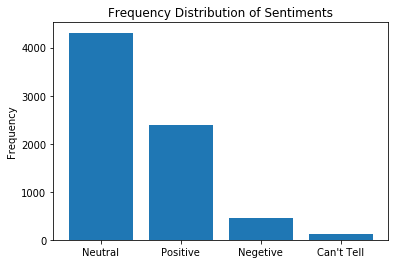

In [20]:
## Checking for class imbalance for target variable
# 0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell
objects = ('Neutral', 'Positive', 'Negetive', 'Can\'t Tell')
y_pos = np.arange(len(sentiments.value_counts()))
plt.bar(y_pos, sentiments.value_counts())
plt.xticks(y_pos,objects)
plt.ylabel("Frequency")
plt.title("Frequency Distribution of Sentiments")

In [21]:
## Dataframe for tweets for training data
tweets = train_data['tweet']
tweets.head()

0                                                          #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller
1    Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw
2               one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}
3                      This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork
4                                                                      Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}
Name: tweet, dtype: object

###### iii) Checking for WordCloud based on each sentiments without data cleaning



WordCloud for sentiment:  0



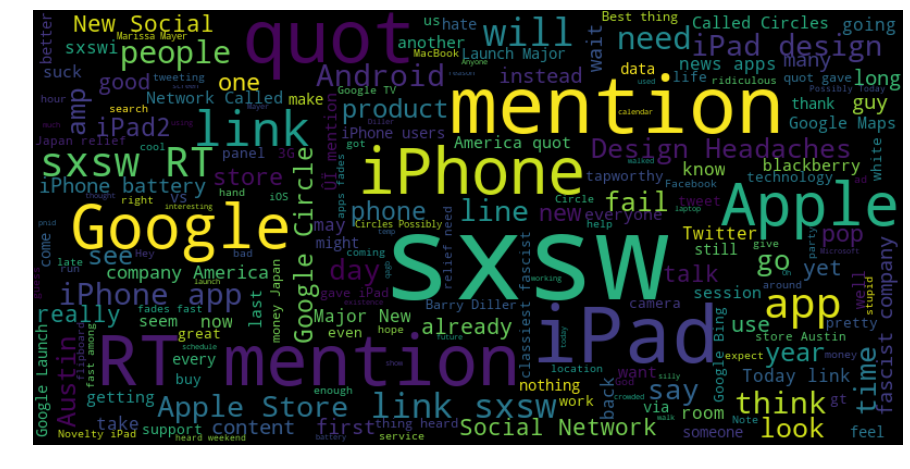


WordCloud for sentiment:  1



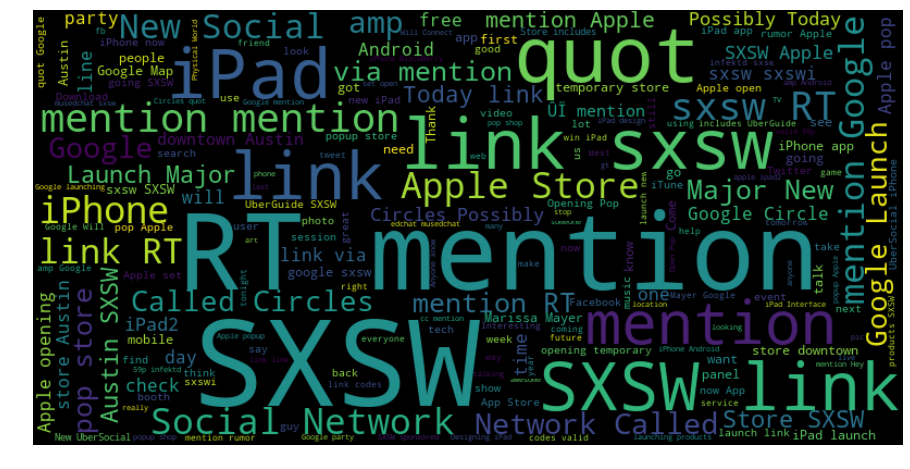


WordCloud for sentiment:  2



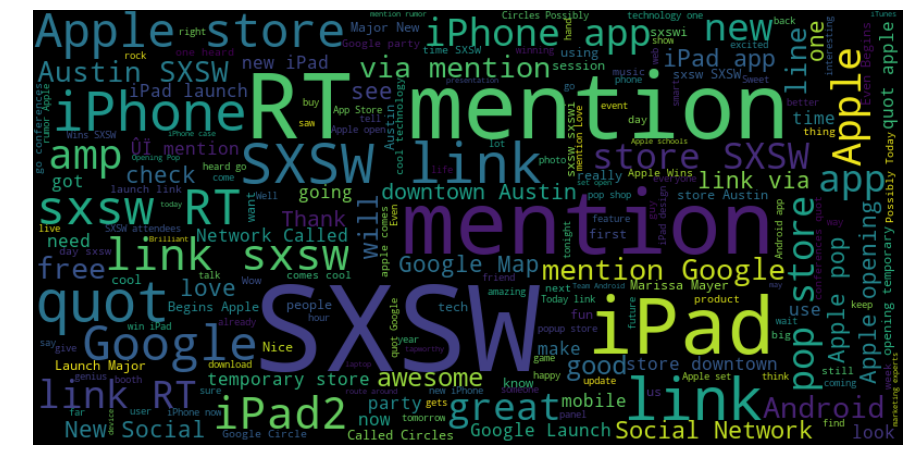


WordCloud for sentiment:  3



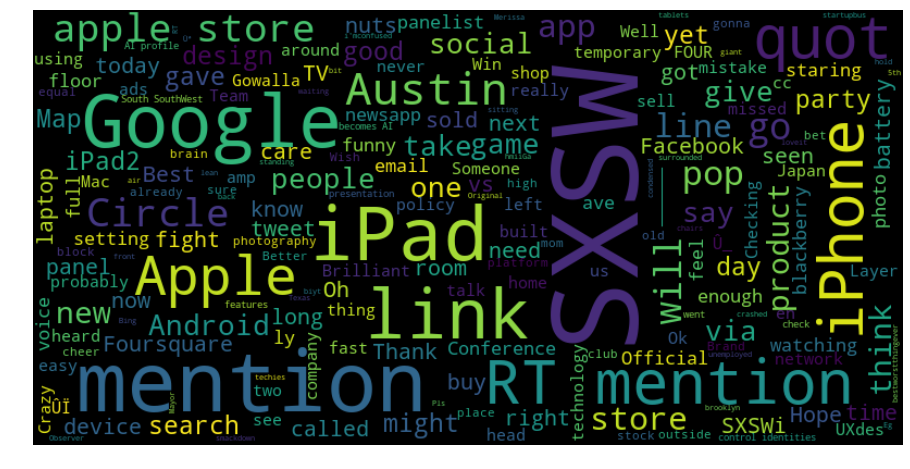

In [22]:
def create_wordcloud(sentiments):
    wordcloud = WordCloud(max_words = 200, max_font_size = 110, 
                random_state = 21, width=800, height=400)
    for i in range(4):
        print()
        print("WordCloud for sentiment: ", i)
        print()
    
        wordcloud.generate(sentiments[i])
        plt.figure(figsize=(16, 8))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.show()
    
sentiment_negative = " ".join([str(text) for text in train_data[train_data['sentiment'] == 0]['tweet']])
sentiment_neutral = " ".join([str(text) for text in train_data[train_data['sentiment'] == 1]['tweet']])
sentiment_positive = " ".join([str(text) for text in train_data[train_data['sentiment'] == 2]['tweet']])
sentiment_cant_tell = " ".join([str(text) for text in train_data[train_data['sentiment'] == 3]['tweet']])
tweets_on_sentiments = [sentiment_negative, sentiment_neutral, sentiment_positive, sentiment_cant_tell]

create_wordcloud(tweets_on_sentiments)
    

It can be seen that data is talking about event SXSW (South by SouthWest Festival). There is nothing much to conclude from this wordcloud with data cleaning. So let's clean data and check the wordcloud.

###### iv) Checking for Retweets

In [23]:
tweets = pd.DataFrame(tweets, columns=['tweet'])

#  Find ReTweets that are just RT or which has user comments in it.
is_retweet = []
for x in tweets['tweet']:
    if 'RT' in str(x):
        is_retweet.append(1)
    else:
        is_retweet.append(0)




In [24]:
tweets['is_retweet_all'] = is_retweet

In [25]:
tweets.head()

tweet  is_retweet_all
0                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller               0
1  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw               0
2             one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}               1
3                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork               0
4                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}               0

In [26]:
## Number of users who retweeted
tweets['is_retweet_all'].sum()

2147

In [27]:
## Finding retweets where user has only retweeted and does not have any comments on it.
tweets['is_retweet'] = tweets['tweet'].astype(str).apply(lambda x: x[:2]=='RT')
tweets.head()

tweet  is_retweet_all  is_retweet
0                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller               0       False
1  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw               0       False
2             one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}               1       False
3                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork               0       False
4                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}               0       False

In [28]:
tweets['is_retweet'].sum()

1586

The above tweets can be considered as duplicate tweets as it are just same repeated tweets with adding nothing to data

In [29]:
## Finding top most repeated retweets
tweets.groupby(['tweet']).size().reset_index(name='counts').sort_values(by='counts', ascending=False).head()

tweet  counts
5069  RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw       5
5068  RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW       4
4782               RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw       3
3800      Need to buy an iPad2 while I'm in Austin at #sxsw. Not sure if I'll need to Q up at an Austin Apple store?       2
1669                                                                  Before It Even Begins, Apple Wins #SXSW {link}       2

In [30]:
## Check distribution of Retweets
counts = tweets.groupby(['tweet']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
counts['counts'].value_counts()

1    7243
2       9
3       1
5       1
4       1
Name: counts, dtype: int64

###### v) Finding hashtags and forming wordcloud for it

In [31]:
tweets = tweets.astype(str)

In [32]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", str(i))
        hashtags.append(ht)

    return hashtags

In [33]:
tweets['hashtags'] = hashtag_extract(tweets['tweet'])
tweets.head()

tweet is_retweet_all is_retweet                       hashtags
0                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller              0      False         [sxswnui, sxsw, apple]
1  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw              0      False           [GoogleDoodle, sxsw]
2             one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}              1      False                         [SXSW]
3                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork              0      False  [SXSW, Fuckit, Illmakeitwork]
4                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}              0      False                         [SXSW]

In [34]:
ht = sum(tweets['hashtags'],[])

>> Forming WordCloud for Hashtags

In [35]:
ht

['sxswnui',
 'sxsw',
 'apple',
 'GoogleDoodle',
 'sxsw',
 'SXSW',
 'SXSW',
 'Fuckit',
 'Illmakeitwork',
 'SXSW',
 'technews',
 'Tech_News',
 'Apple',
 'iPad_2',
 'SXSW',
 'tablets',
 'tech',
 'sxsw',
 'ipad',
 'UberSocial',
 'iPhone',
 'SXSW',
 'Mashable',
 'SXSW',
 'FreeMusic',
 'sxsw',
 'SXSW',
 'android',
 'iphone',
 'ipad',
 'SXSW',
 'elevate',
 'sxsw',
 'techenvy',
 'SXSW',
 'zazzlsxsw',
 'Companies',
 'SXSW',
 'apps',
 'features',
 'hardware',
 'ipad',
 'iphone',
 'sxsw',
 'Calyp',
 'Calyp',
 'SXSW',
 'sxsw',
 'apple',
 'iPad2',
 'technology',
 'iTunes',
 'SXSW',
 'sxsw',
 'doubleloser',
 'SXSW',
 'sxsw',
 'sxsw',
 'sxsw',
 'RISE_Austin',
 'SXSW',
 'circles',
 'SXSW',
 'Circles',
 'sxsw',
 'SXSW',
 'sxsw',
 'sxsw',
 'startups',
 'VC',
 'movie',
 'awesome',
 'sxsw',
 'Apple',
 'SXSW',
 'SXSW',
 'sxsw',
 'iPad',
 'sxsw',
 'iPad',
 'sxsw',
 'SXSW',
 'sxsw',
 'SXSW',
 'DeferoMobile',
 'ipad2',
 'sxsw',
 'sxsw',
 'apple',
 'ipad2',
 'SXSW',
 'fb',
 'sxsw',
 'Android',
 'iPhone',
 'SMS

In [36]:
ht1 = " ".join([(str(x).lower()) for x in ht])

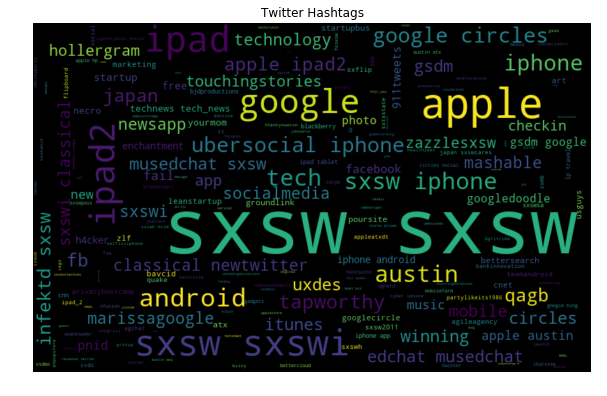

In [37]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(ht1)
plt.figure(figsize=(10, 7))
plt.title('Twitter Hashtags')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

>> Frequency Distribution of Hashtags

In [38]:
## Top 10 hashtags
ht2 = [x.lower() for x in ht]
ht2

['sxswnui',
 'sxsw',
 'apple',
 'googledoodle',
 'sxsw',
 'sxsw',
 'sxsw',
 'fuckit',
 'illmakeitwork',
 'sxsw',
 'technews',
 'tech_news',
 'apple',
 'ipad_2',
 'sxsw',
 'tablets',
 'tech',
 'sxsw',
 'ipad',
 'ubersocial',
 'iphone',
 'sxsw',
 'mashable',
 'sxsw',
 'freemusic',
 'sxsw',
 'sxsw',
 'android',
 'iphone',
 'ipad',
 'sxsw',
 'elevate',
 'sxsw',
 'techenvy',
 'sxsw',
 'zazzlsxsw',
 'companies',
 'sxsw',
 'apps',
 'features',
 'hardware',
 'ipad',
 'iphone',
 'sxsw',
 'calyp',
 'calyp',
 'sxsw',
 'sxsw',
 'apple',
 'ipad2',
 'technology',
 'itunes',
 'sxsw',
 'sxsw',
 'doubleloser',
 'sxsw',
 'sxsw',
 'sxsw',
 'sxsw',
 'rise_austin',
 'sxsw',
 'circles',
 'sxsw',
 'circles',
 'sxsw',
 'sxsw',
 'sxsw',
 'sxsw',
 'startups',
 'vc',
 'movie',
 'awesome',
 'sxsw',
 'apple',
 'sxsw',
 'sxsw',
 'sxsw',
 'ipad',
 'sxsw',
 'ipad',
 'sxsw',
 'sxsw',
 'sxsw',
 'sxsw',
 'deferomobile',
 'ipad2',
 'sxsw',
 'sxsw',
 'apple',
 'ipad2',
 'sxsw',
 'fb',
 'sxsw',
 'android',
 'iphone',
 'sms

In [39]:
top10_hashtags = pd.Series(ht2).value_counts()[:10]
top10_hashtags

sxsw       7293
apple       337
google      255
sxswi       249
ipad2       234
iphone      215
ipad        205
android     104
austin       94
circles      92
dtype: int64

<BarContainer object of 10 artists>

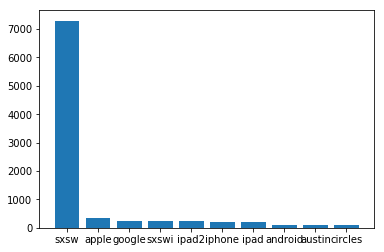

In [40]:
plt.bar(top10_hashtags.index, height=top10_hashtags.values )

In [41]:
train_data.head()

tweet_id                                                                                                                                            tweet  sentiment
0      1701                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller          1
1      1851  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw          1
2      2689             one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}          2
3      4525                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork          0
4      3604                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}          1

In [42]:
## Hashtags based on Negative sentiments
ht_negative = train_data[train_data['sentiment'] == 0]['tweet']
ht_negative.head()

3                This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork
24              .@mention I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
34    So I went the whole day w/out my laptop &amp; just used my iPad 1. Things I missed: FTP, cloudapp, fast typing, &amp; skype. #iPad #sxsw
50                                 RT @mention 'Google lost its way by caring too much for the business vs. the users' - @mention #psych #sxsw
63    I composed a tweet so acerbic and cynical about ipad users that my phone crashed and dumped all my apps. #twitterpower #sxsw #imthatgood
Name: tweet, dtype: object

In [43]:
ht_negative = sum(hashtag_extract(ht_negative),[])
ht_negative

['SXSW',
 'Fuckit',
 'Illmakeitwork',
 'RISE_Austin',
 'SXSW',
 'iPad',
 'sxsw',
 'psych',
 'sxsw',
 'twitterpower',
 'sxsw',
 'imthatgood',
 'SXSW',
 'netflixiphone',
 'ipad2',
 'SXSW',
 'sxsw',
 'fail',
 'owllove',
 'sxsw',
 'enchantment',
 'SXSW',
 'sxswi',
 'SXSW',
 'SXSW',
 'Sxsw',
 'SXSW',
 'SXSW',
 'sxsw',
 'qagb',
 'sxsw',
 'sxsw',
 'SXSW',
 'CNNGrill',
 'sxsw',
 'sxsw',
 'csr',
 'sxsw',
 'AT',
 'Mullenweg',
 'sxsw',
 'sxsw',
 'SXSW',
 'CNN',
 'SXSW',
 'SXSW',
 'sxsw',
 'sxsw',
 'Google',
 'Circles',
 'Social',
 'SXSW',
 'sxsw',
 'sxsw',
 'osmpw',
 'sxsw',
 'SXSW',
 'iPad',
 'sxsw',
 'sxsw',
 'sxsw',
 'SXSW',
 'sxsw',
 'fail',
 'Google',
 'sxsw',
 'pnid',
 'SXSW',
 '100tc',
 'sxswi',
 'sxsw',
 'iPad',
 'sxsw',
 'tapworthy',
 'sxsw',
 'futuremf',
 'sxsw',
 'ogilvynotes',
 'sxsw',
 'Apple',
 'sxsw',
 'rji',
 'sxsw',
 'sxsw',
 'SXSW',
 'sxsw',
 'sxsw',
 'socialfuel',
 'sxsw',
 'seenocreepy',
 'sxsw',
 'PNID',
 'sxsw',
 'SXSW',
 'SXSW',
 'web3',
 'SaatchiNY',
 'SXSW',
 'iPad',
 'ap

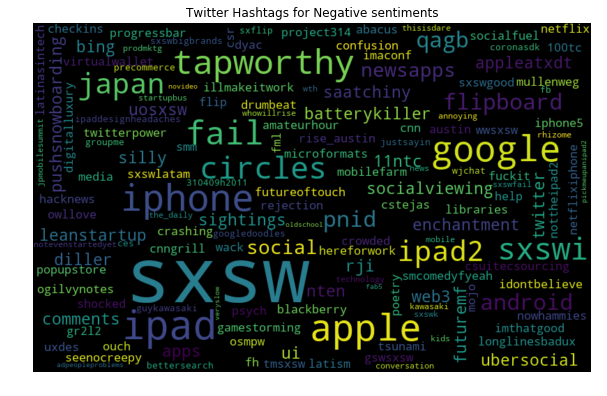

In [44]:
ht_negative1 = " ".join([(str(x).lower()) for x in ht_negative])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(ht_negative1)
plt.figure(figsize=(10, 7))
plt.title('Twitter Hashtags for Negative sentiments')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [45]:
ht_negative1

'sxsw fuckit illmakeitwork rise_austin sxsw ipad sxsw psych sxsw twitterpower sxsw imthatgood sxsw netflixiphone ipad2 sxsw sxsw fail owllove sxsw enchantment sxsw sxswi sxsw sxsw sxsw sxsw sxsw sxsw qagb sxsw sxsw sxsw cnngrill sxsw sxsw csr sxsw at mullenweg sxsw sxsw sxsw cnn sxsw sxsw sxsw sxsw google circles social sxsw sxsw sxsw osmpw sxsw sxsw ipad sxsw sxsw sxsw sxsw sxsw fail google sxsw pnid sxsw 100tc sxswi sxsw ipad sxsw tapworthy sxsw futuremf sxsw ogilvynotes sxsw apple sxsw rji sxsw sxsw sxsw sxsw sxsw socialfuel sxsw seenocreepy sxsw pnid sxsw sxsw sxsw web3 saatchiny sxsw ipad apps media sxsw sxsw tapworthy sxsw android sxsw sxsw rejection project314 sxsw sxsw sxsw sxsw qagb blackberry abacus iphone sxsw sxsw socialviewing sxsw sxsw cstejas sxsw ipad sxsw sxsw wwsxsw tapworthy sxsw libraries sxsw sxsw iphone sxsw flip sxsw sxsw tapworthy sxsw sxsw sxsw diller iphone sxsw fml sxsw google circles social sxsw apple idontbelieve sxsw pushsnowboarding sxsw sxsw sxsw sxsw ip

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

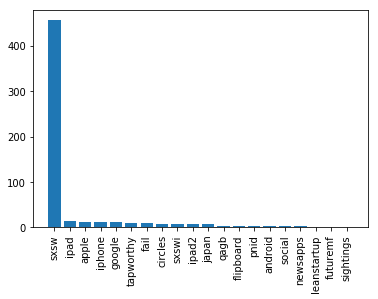

In [46]:
## Top 10 hashtags for Negative sentiment
ht_negative2 = [x.lower() for x in ht_negative]

top10_hashtags = pd.Series(ht_negative2).value_counts()[:20]
plt.bar(top10_hashtags.index, height=top10_hashtags.values )
plt.xticks(rotation = 90)

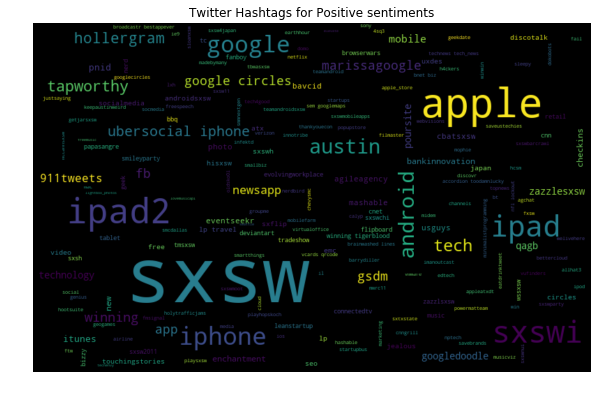

In [47]:
## Hashtags based on Positive sentiments
ht_positive = train_data[train_data['sentiment'] == 2]['tweet']
ht_positive.head()

ht_positive = sum(hashtag_extract(ht_positive),[])

ht_positive1 = " ".join([(str(x).lower()) for x in ht_positive])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(ht_positive1)
plt.figure(figsize=(10, 7))
plt.title('Twitter Hashtags for Positive sentiments')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

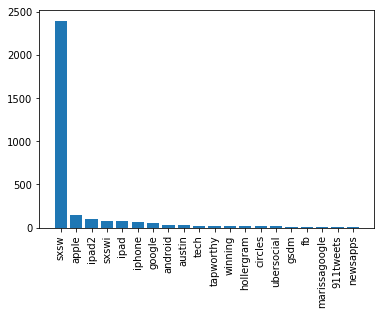

In [48]:
## Top 10 hashtags for Positive sentiment
ht_positive2 = [x.lower() for x in ht_positive]

top10_hashtags = pd.Series(ht_positive2).value_counts()[:20]
plt.bar(top10_hashtags.index, height=top10_hashtags.values )
plt.xticks(rotation = 90)

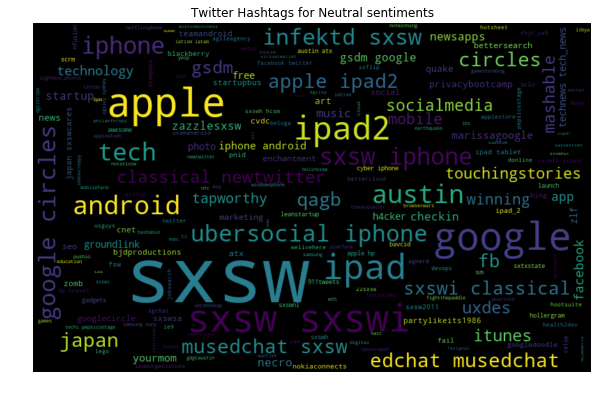

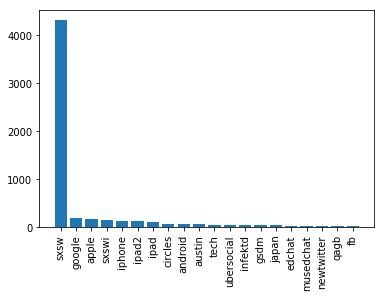

In [49]:
## Hashtags based on Neutral sentiments
ht_neutral = train_data[train_data['sentiment'] == 1]['tweet']
ht_neutral.head()

ht_neutral = sum(hashtag_extract(ht_neutral),[])

ht_neutral1 = " ".join([(str(x).lower()) for x in ht_neutral])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(ht_neutral1)
plt.figure(figsize=(10, 7))
plt.title('Twitter Hashtags for Neutral sentiments')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Top 10 hashtags for Neutral sentiment
ht_neutral2 = [x.lower() for x in ht_neutral]

top10_hashtags = pd.Series(ht_neutral2).value_counts()[:20]
plt.bar(top10_hashtags.index, height=top10_hashtags.values )
plt.xticks(rotation = 90)
plt.show()

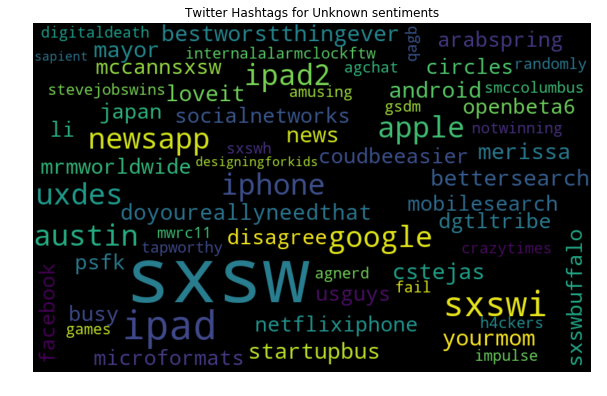

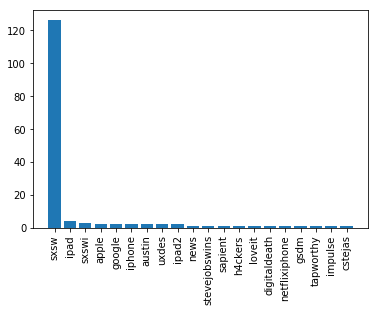

In [50]:
## Hashtags based on Unknown sentiments
ht_unknown = train_data[train_data['sentiment'] == 3]['tweet']
ht_unknown.head()

ht_unknown = sum(hashtag_extract(ht_unknown),[])

ht_unknown1 = " ".join([(str(x).lower()) for x in ht_unknown])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(ht_unknown1)
plt.figure(figsize=(10, 7))
plt.title('Twitter Hashtags for Unknown sentiments')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Top 10 hashtags for Unknown sentiment
ht_unknown2 = [x.lower() for x in ht_unknown]

top10_hashtags = pd.Series(ht_unknown2).value_counts()[:20]
plt.bar(top10_hashtags.index, height=top10_hashtags.values )
plt.xticks(rotation = 90)
plt.show()

vi) Finding smileys and checking happy and sad tweets based on smileys

In [51]:
#HappyEmoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

# SadEmoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

In [52]:
#  Happy and Sad Emoticons list
Happy_Smiley = []
temp_tweets = []
Sad_Smiley = []
for i,tweet in enumerate(tweets.tweet):
  for smiley in emoticons_happy:
    for word in tweet.split():
      if smiley == word:
        temp_tweets.append(1)
        Happy_Smiley.append(smiley)
  for smiley in emoticons_sad:
    for word in tweet.split():
      if smiley == word:
        temp_tweets.append(0)
        Sad_Smiley.append(smiley)


In [53]:
happy = sum(temp_tweets)
sad = len(temp_tweets) - sum(temp_tweets)
print("Total Number of Happy emoticon: ", happy)
print("Total number with Sad emoticon: ", sad)
print()
print("Ratio of happy emoticon used: ", happy/len(temp_tweets))
print("Ratio of sad emoticon used: ", sad/len(temp_tweets))

Total Number of Happy emoticon:  150
Total number with Sad emoticon:  23

Ratio of happy emoticon used:  0.8670520231213873
Ratio of sad emoticon used:  0.1329479768786127


In [54]:
pd.Series(Happy_Smiley).value_counts()

:)     83
;)     26
:-)    20
:D      7
xD      3
:P      3
=)      2
:-D     2
=D      1
:p      1
:]      1
XD      1
dtype: int64

Text(0, 0.5, 'Frequency')

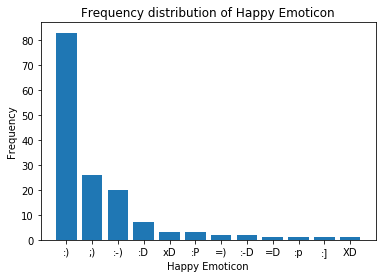

In [55]:
plt.title("Frequency distribution of Happy Emoticon")
plt.bar(pd.Series(Happy_Smiley).value_counts().index,pd.Series(Happy_Smiley).value_counts().values)
plt.xlabel("Happy Emoticon")
plt.ylabel("Frequency")

In [56]:
pd.Series(Sad_Smiley).value_counts()

:(     16
:-(     5
:-/     2
dtype: int64

Text(0, 0.5, 'Frequency')

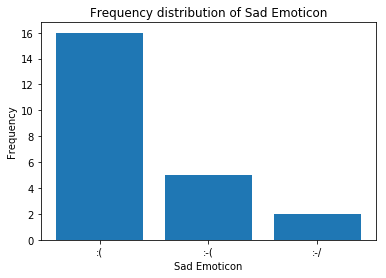

In [57]:
plt.title("Frequency distribution of Sad Emoticon")
plt.bar(pd.Series(Sad_Smiley).value_counts().index,pd.Series(Sad_Smiley).value_counts().values)
plt.xlabel("Sad Emoticon")
plt.ylabel("Frequency")

3) **Data Preprocessing**

In [58]:
train_data.head(10)

tweet_id                                                                                                                                            tweet  sentiment
0      1701                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller          1
1      1851  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw          1
2      2689             one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}          2
3      4525                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork          0
4      3604                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}          1
5       966                              #technews One lone dude awaits iPad 2 at AppleÛªs SXSW store {link} #Tech_News #Apple #iPad_2 #SXSW #tablets #tech          1
6      1395                                                             SXSW Tips, Prince, NPR Videos, Toy Shopping With Zuckerberg.\r\n{link}  #sxsw  #ipad          1
7      8182                          NU user RT @mention New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXSW sponsored by #Mashable          1
8      8835                                                                                                   Free #SXSW sampler on iTunes {link} #FreeMusic          2
9       883                                                                  I think I might go all weekend without seeing the same iPad case twice... #sxsw          2

>> i) Append train and test data

In [59]:
train_id = train_data['tweet_id']
test_id = test_data['tweet_id']

In [60]:
train = train_data['tweet']
test = test_data['tweet']
target = train_data['sentiment']
all_data = train.append(test, ignore_index=True)
all_data.shape

(9092,)

In [61]:
all_data = pd.DataFrame(all_data, columns=['tweet'])
all_data.head()

tweet
0                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller
1  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw
2             one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}
3                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork
4                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}

In [62]:
all_data = all_data.astype(str)

>> ii) Remove user handles 

In [63]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt    

In [64]:
all_data['clean_tweet'] = all_data['tweet'].apply(lambda row:remove_pattern(row, "@[\w]*"))
all_data.head()

tweet                                                                                                                                      clean_tweet
0                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller
1  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw
2             one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}                     one of the most in-your-face ex. of stealing the show in yrs RT  &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}
3                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork
4                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}

>> iii) Based on EDA we can see '#' are not contributing any value to the sentiments, hence dropping '#'

In [65]:
all_data.head()

tweet                                                                                                                                      clean_tweet
0                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller
1  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw
2             one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}                     one of the most in-your-face ex. of stealing the show in yrs RT  &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}
3                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork
4                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}

In [66]:
def remove_hashtag(x):
    r = re.findall(r"#(\w+)", x)
    for i in r:
        x = re.sub(i, '', x)
    return x  

In [67]:
all_data['clean_tweet'] = all_data['clean_tweet'].apply(lambda row: remove_hashtag(row))
all_data.head()

tweet                                                                                                                      clean_tweet
0                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller                                                        # # # defining language of touch with different dialects becoming smaller
1  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. # #
2             one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}         one of the most in-your-face ex. of stealing the show in yrs RT  &quot;At #, Apple schools the mkt experts&quot;  {link}
3                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork                           This iPhone # app would b pretty awesome if it didn't crash every 10mins during extended browsing. # #
4                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}                                                        Line outside the Apple store in Austin waiting for the new iPad #  {link}

>> iv) Remove Stopwords

In [68]:
punctuation = list(string.punctuation)

In [69]:
stop_words = list((stopwords.words('english')))+list(punctuation)+['``', "'s", "...", "n't"] + ['rt','mention','link','video','cont','in','get','via']
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [70]:
all_data['clean_tweet'] = [str(word).lower() for word in all_data['clean_tweet']]
all_data.head()

tweet                                                                                                                      clean_tweet
0                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller                                                        # # # defining language of touch with different dialects becoming smaller
1  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw  learning ab google doodles! all doodles should be light, funny &amp; innovative, with exceptions for significant occasions. # #
2             one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}         one of the most in-your-face ex. of stealing the show in yrs rt  &quot;at #, apple schools the mkt experts&quot;  {link}
3                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork                           this iphone # app would b pretty awesome if it didn't crash every 10mins during extended browsing. # #
4                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}                                                        line outside the apple store in austin waiting for the new ipad #  {link}

In [71]:
## Tokenize
all_data['tokenized_text'] = [nltk.word_tokenize(x) for x in all_data['clean_tweet']]
all_data.head()

tweet                                                                                                                      clean_tweet                                                                                                                                                    tokenized_text
0                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller                                                        # # # defining language of touch with different dialects becoming smaller                                                                            [#, #, #, defining, language, of, touch, with, different, dialects, becoming, smaller]
1  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw  learning ab google doodles! all doodles should be light, funny &amp; innovative, with exceptions for significant occasions. # #   [learning, ab, google, doodles, !, all, doodles, should, be, light, ,, funny, &, amp, ;, innovative, ,, with, exceptions, for, significant, occasions, ., #, #]
2             one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}         one of the most in-your-face ex. of stealing the show in yrs rt  &quot;at #, apple schools the mkt experts&quot;  {link}  [one, of, the, most, in-your-face, ex, ., of, stealing, the, show, in, yrs, rt, &, quot, ;, at, #, ,, apple, schools, the, mkt, experts, &, quot, ;, {, link, }]
3                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork                           this iphone # app would b pretty awesome if it didn't crash every 10mins during extended browsing. # #                                    [this, iphone, #, app, would, b, pretty, awesome, if, it, did, n't, crash, every, 10mins, during, extended, browsing, ., #, #]
4                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}                                                        line outside the apple store in austin waiting for the new ipad #  {link}                                                                       [line, outside, the, apple, store, in, austin, waiting, for, the, new, ipad, #, {, link, }]

In [72]:
##Removing Stopwords
all_data['tokenized_text'] = all_data['tokenized_text'].apply(lambda row: [word for word in row if word not in stop_words])
all_data.head()

tweet                                                                                                                      clean_tweet                                                                                               tokenized_text
0                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller                                                        # # # defining language of touch with different dialects becoming smaller                                          [defining, language, touch, different, dialects, becoming, smaller]
1  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw  learning ab google doodles! all doodles should be light, funny &amp; innovative, with exceptions for significant occasions. # #  [learning, ab, google, doodles, doodles, light, funny, amp, innovative, exceptions, significant, occasions]
2             one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}         one of the most in-your-face ex. of stealing the show in yrs rt  &quot;at #, apple schools the mkt experts&quot;  {link}                       [one, in-your-face, ex, stealing, show, yrs, quot, apple, schools, mkt, experts, quot]
3                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork                           this iphone # app would b pretty awesome if it didn't crash every 10mins during extended browsing. # #                           [iphone, app, would, b, pretty, awesome, crash, every, 10mins, extended, browsing]
4                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}                                                        line outside the apple store in austin waiting for the new ipad #  {link}                                                    [line, outside, apple, store, austin, waiting, new, ipad]

>> v) Removing numbers and word having length less than 3

In [73]:
def remove_numbers(list): 
    pattern = '[0-9]'
    list = [re.sub(pattern, '', str(i)) for i in list] 
    return list

In [74]:
all_data['tokenized_text'] = all_data['tokenized_text'].apply(lambda x:remove_numbers(x))
all_data.head()


tweet                                                                                                                      clean_tweet                                                                                               tokenized_text
0                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller                                                        # # # defining language of touch with different dialects becoming smaller                                          [defining, language, touch, different, dialects, becoming, smaller]
1  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw  learning ab google doodles! all doodles should be light, funny &amp; innovative, with exceptions for significant occasions. # #  [learning, ab, google, doodles, doodles, light, funny, amp, innovative, exceptions, significant, occasions]
2             one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}         one of the most in-your-face ex. of stealing the show in yrs rt  &quot;at #, apple schools the mkt experts&quot;  {link}                       [one, in-your-face, ex, stealing, show, yrs, quot, apple, schools, mkt, experts, quot]
3                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork                           this iphone # app would b pretty awesome if it didn't crash every 10mins during extended browsing. # #                             [iphone, app, would, b, pretty, awesome, crash, every, mins, extended, browsing]
4                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}                                                        line outside the apple store in austin waiting for the new ipad #  {link}                                                    [line, outside, apple, store, austin, waiting, new, ipad]

In [75]:
all_data['tokenized_text'] = all_data['tokenized_text'].apply(lambda x: [w for w in x if len(w)>3])
all_data.head()

tweet                                                                                                                      clean_tweet                                                                                      tokenized_text
0                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller                                                        # # # defining language of touch with different dialects becoming smaller                                 [defining, language, touch, different, dialects, becoming, smaller]
1  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw  learning ab google doodles! all doodles should be light, funny &amp; innovative, with exceptions for significant occasions. # #  [learning, google, doodles, doodles, light, funny, innovative, exceptions, significant, occasions]
2             one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}         one of the most in-your-face ex. of stealing the show in yrs rt  &quot;at #, apple schools the mkt experts&quot;  {link}                                 [in-your-face, stealing, show, quot, apple, schools, experts, quot]
3                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork                           this iphone # app would b pretty awesome if it didn't crash every 10mins during extended browsing. # #                            [iphone, would, pretty, awesome, crash, every, mins, extended, browsing]
4                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}                                                        line outside the apple store in austin waiting for the new ipad #  {link}                                                [line, outside, apple, store, austin, waiting, ipad]

In [76]:
all_data['tokenized_text'] = all_data['tokenized_text'].apply(lambda row: " ".join(row))
all_data.head()

tweet                                                                                                                      clean_tweet                                                                           tokenized_text
0                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller                                                        # # # defining language of touch with different dialects becoming smaller                              defining language touch different dialects becoming smaller
1  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw  learning ab google doodles! all doodles should be light, funny &amp; innovative, with exceptions for significant occasions. # #  learning google doodles doodles light funny innovative exceptions significant occasions
2             one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}         one of the most in-your-face ex. of stealing the show in yrs rt  &quot;at #, apple schools the mkt experts&quot;  {link}                               in-your-face stealing show quot apple schools experts quot
3                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork                           this iphone # app would b pretty awesome if it didn't crash every 10mins during extended browsing. # #                           iphone would pretty awesome crash every mins extended browsing
4                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}                                                        line outside the apple store in austin waiting for the new ipad #  {link}                                             line outside apple store austin waiting ipad

4) Exploratory Data analysis
>> i) Top words used in tweets 

>> ii) Bi-grams based on sentiments

>> iii) Tri-grams based on sentiments

In [77]:
words = " ".join([str(text) for text in all_data['tokenized_text']])
words

"defining language touch different dialects becoming smaller learning google doodles doodles light funny innovative exceptions significant occasions in-your-face stealing show quot apple schools experts quot iphone would pretty awesome crash every mins extended browsing line outside apple store austin waiting ipad lone dude awaits ipad \x89ûªs store sxsw tips prince videos shopping zuckerberg user store includes uberguide sponsored free sampler itunes think might weekend without seeing ipad case twice official go\x89ûª bit.ly/hmiiga official buying ipad giving away ipad boxes books officially come grill you\x89ûªll make iphone case watch trade show floor google marissa mayer future location augmented reality contextual discovery make smartphones smarter casa free mobile available itunes store android market well yeah music iphone nerds cute girls everywhere love interactive ends music begins apple opens store atleast ipad choir music apple store anyone want ipad line pick someone willi

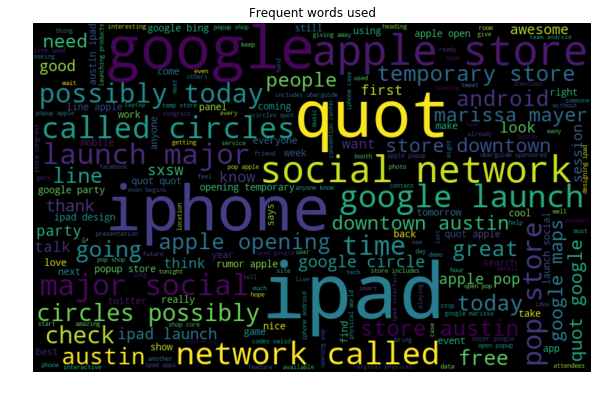

In [78]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)
plt.figure(figsize=(10, 7))
plt.title('Frequent words used')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [79]:
cleaned_train = all_data[:train_id.shape[0]]
cleaned_train.tail()

tweet                                                                                                                       clean_tweet                                                                    tokenized_text
7268                                                 @mention Google plze Tammi.  I'm in middle of #SXSW craziness and everything is soooooo busy!                                                  google plze tammi.  i'm in middle of # craziness and everything is soooooo busy!                        google plze tammi middle craziness everything soooooo busy
7269                                                   RT @mention ÷¼ Are you all set? ÷_ {link} ÷_ #edchat #musedchat #sxsw #sxswi #newTwitter                                                                             rt  ÷¼ are you all set? ÷_ {link} ÷_ # #mus # #i #                                                                                  
7270  RT @mention Aha! Found proof of lactation room, excuse me, &quot;Mother's Room,&quot; brought to you by Google, at last year's #SXSW. {link}  rt  aha! found proof of lactation room, excuse me, &quot;mother's room,&quot; brought to you by google, at last year's #. {link}  found proof lactation room excuse quot mother room quot brought google last year
7271                                                  We just launched our iPad app at #SXSW! Get all the details + the first edition FREE: {link}                                          we just launched our ipad app at #! get all the details + the first edition free: {link}                                          launched ipad details first edition free
7272     The next fin serv battle is vs Apple, GOOG, Mobile operators. They have consumer loyalty and tons of cash (vs. Banks) #bankinnovate #SXSW         the next fin serv battle is vs apple, goog, mobile operators. they have consumer loyalty and tons of cash (vs. banks) # #     next serv battle apple goog mobile operators consumer loyalty tons cash banks

In [80]:
cleaned_test = all_data[7273:]
cleaned_test.head()

tweet                                                                                                                  clean_tweet                                                                             tokenized_text
7273  Audience Q: What prototyping tools do you use? Sketchbooks/sharpie pens, photoshop, Balsamic, Google docs, Axsure, etc. #myprototype #sxsw  audience q: what prototyping tools do you use? sketchbooks/sharpie pens, photoshop, balsamic, google docs, axsure, etc. # #  audience prototyping tools sketchbooks/sharpie pens photoshop balsamic google docs axsure
7274                At SXSW? Send Your Best Photos &amp; Videos to... {link} #citizen_journalism #cnn #ireport #photography #sxsw #Cyber #iPhone                                                       at sxsw? send your best photos &amp; videos to... {link} # # # # # # #                                                               sxsw send best photos videos
7275                                @mention  and here's a pic of you winning your ipad! #unsix #sxsw cc @mention @mention  {link} (cont) {link}                                                    and here's a pic of you winning your ipad! # # cc    {link} (cont) {link}                                                                               winning ipad
7276               Google Marissa Mayer: mobile phone as a cursor of physical location - new version of map fast and more real life like   #sxsw    google marissa mayer: mobile phone as a cursor of physical location - new version of map fast and more real life like   #     google marissa mayer mobile phone cursor physical location version fast real life like
7277                                                                                             #SXSW Google maps is even cooler than I thought                                                                                  # google maps is even cooler than i thought                                                            google maps even cooler thought

In [81]:
cleaned_train_copy = cleaned_train.copy()
cleaned_train_copy['sentiment'] = target

In [82]:
## Bi-grams based on sentiments
def Bigrams(corpus):
    words = [word.lower().split() for word in corpus]
    words = [list(bigrams(word)) for word in words]
    all_words = list(itertools.chain(*words))
    counts = collections.Counter(all_words)
    df1 = pd.DataFrame(counts.most_common(20),columns=['words', 'count'])
    return df1
    

Text(0.5, 0, 'Frequency of bigrams')

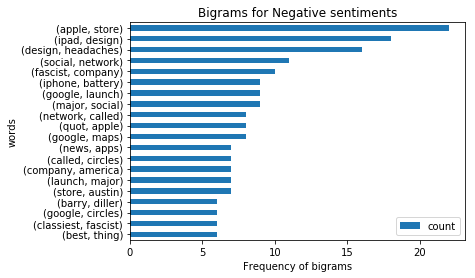

In [83]:
## Bi-gram on Negative sentiments
negative = cleaned_train_copy[cleaned_train_copy['sentiment']==0]['tokenized_text']
negative_df = Bigrams(negative)
negative_df.sort_values(by='count').plot.barh(x='words',y='count')
plt.title("Bigrams for Negative sentiments")
plt.xlabel("Frequency of bigrams")

Text(0.5, 0, 'Frequency of bigrams')

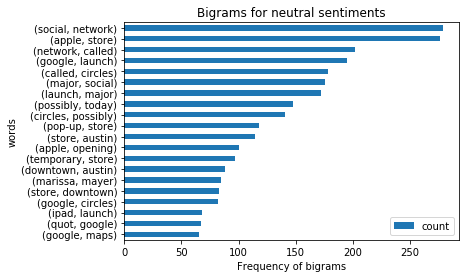

In [84]:
## Bi-gram on Neutral sentiments
neutral = cleaned_train_copy[cleaned_train_copy['sentiment']==1]['tokenized_text']
neutral_df = Bigrams(neutral)
neutral_df.sort_values(by='count').plot.barh(x='words',y='count')
plt.title("Bigrams for neutral sentiments")
plt.xlabel("Frequency of bigrams")

Text(0.5, 0, 'Frequency of bigrams')

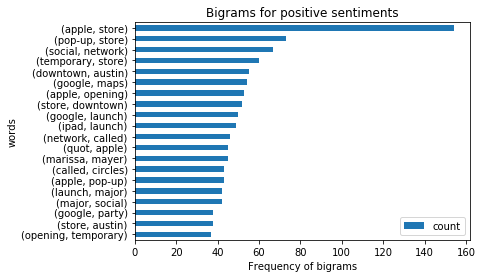

In [85]:
## Bi-gram on positive sentiments
positive = cleaned_train_copy[cleaned_train_copy['sentiment']==2]['tokenized_text']
positive_df = Bigrams(positive)
positive_df.sort_values(by='count').plot.barh(x='words',y='count')
plt.title("Bigrams for positive sentiments")
plt.xlabel("Frequency of bigrams")

Text(0.5, 0, 'Frequency of bigrams')

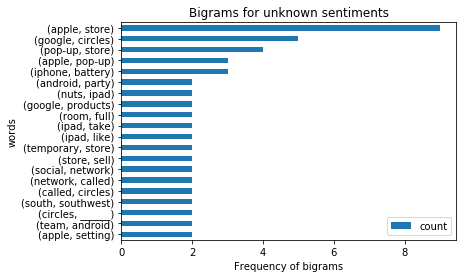

In [86]:
## Bi-gram on unknown sentiments
unknown = cleaned_train_copy[cleaned_train_copy['sentiment']==3]['tokenized_text']
unknown_df = Bigrams(unknown)
unknown_df.sort_values(by='count').plot.barh(x='words',y='count')
plt.title("Bigrams for unknown sentiments")
plt.xlabel("Frequency of bigrams")

In [87]:
## Tri-grams based on sentiments
def Trigrams(corpus):
    words = [word.lower().split() for word in corpus]
    words = [list(trigrams(word)) for word in words]
    all_words = list(itertools.chain(*words))
    counts = collections.Counter(all_words)
    df1 = pd.DataFrame(counts.most_common(20),columns=['words', 'count'])
    return df1
    

Text(0.5, 0, 'Frequency of bigrams')

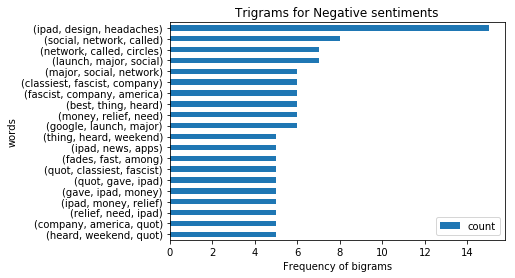

In [88]:
## Tri-gram on Negative sentiments
negative = cleaned_train_copy[cleaned_train_copy['sentiment']==0]['tokenized_text']
negative_df = Trigrams(negative)
negative_df.sort_values(by='count').plot.barh(x='words',y='count')
plt.title("Trigrams for Negative sentiments")
plt.xlabel("Frequency of bigrams")

Text(0.5, 0, 'Frequency of bigrams')

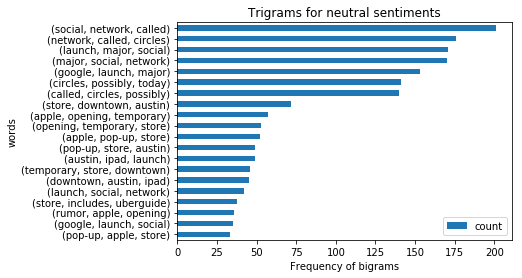

In [89]:
## Trigrams on Neutral sentiments
neutral = cleaned_train_copy[cleaned_train_copy['sentiment']==1]['tokenized_text']
neutral_df = Trigrams(neutral)
neutral_df.sort_values(by='count').plot.barh(x='words',y='count')
plt.title("Trigrams for neutral sentiments")
plt.xlabel("Frequency of bigrams")

Text(0.5, 0, 'Frequency of bigrams')

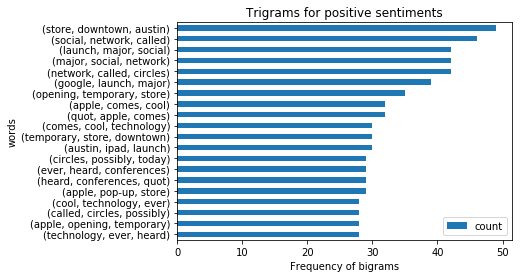

In [90]:
## Trigrams on positive sentiments
positive = cleaned_train_copy[cleaned_train_copy['sentiment']==2]['tokenized_text']
positive_df = Trigrams(positive)
positive_df.sort_values(by='count').plot.barh(x='words',y='count')
plt.title("Trigrams for positive sentiments")
plt.xlabel("Frequency of bigrams")

Text(0.5, 0, 'Frequency of bigrams')

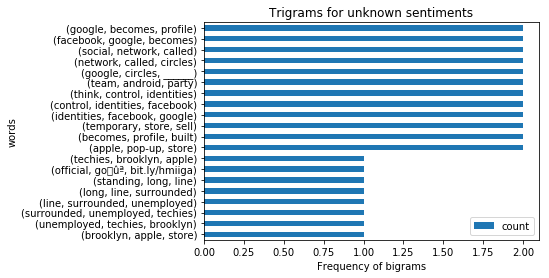

In [91]:
## Trigrams on unknown sentiments
unknown = cleaned_train_copy[cleaned_train_copy['sentiment']==3]['tokenized_text']
unknown_df = Trigrams(unknown)
unknown_df.sort_values(by='count').plot.barh(x='words',y='count')
plt.title("Trigrams for unknown sentiments")
plt.xlabel("Frequency of bigrams")

5) Approach 1

>>i) Stemming and then Count Vectorizer

>>>>a) Applying Base models

>>>>b) Applying Optimized models

>>ii) Stemming and then Count Vectorizer

>>>>a) Applying Base models

>>>>b) Applying Optimized models

>> Approach 1
>>>> i) Count Vectorizer on Stemming

In [92]:
## Stemming with Count Vectorizer
all_data.head()

tweet                                                                                                                      clean_tweet                                                                           tokenized_text
0                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller                                                        # # # defining language of touch with different dialects becoming smaller                              defining language touch different dialects becoming smaller
1  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw  learning ab google doodles! all doodles should be light, funny &amp; innovative, with exceptions for significant occasions. # #  learning google doodles doodles light funny innovative exceptions significant occasions
2             one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}         one of the most in-your-face ex. of stealing the show in yrs rt  &quot;at #, apple schools the mkt experts&quot;  {link}                               in-your-face stealing show quot apple schools experts quot
3                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork                           this iphone # app would b pretty awesome if it didn't crash every 10mins during extended browsing. # #                           iphone would pretty awesome crash every mins extended browsing
4                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}                                                        line outside the apple store in austin waiting for the new ipad #  {link}                                             line outside apple store austin waiting ipad

In [93]:
all_data['tokenized_text'] = all_data['tokenized_text'].apply(lambda row: row.lower().split())
all_data.head()

tweet                                                                                                                      clean_tweet                                                                                      tokenized_text
0                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller                                                        # # # defining language of touch with different dialects becoming smaller                                 [defining, language, touch, different, dialects, becoming, smaller]
1  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw  learning ab google doodles! all doodles should be light, funny &amp; innovative, with exceptions for significant occasions. # #  [learning, google, doodles, doodles, light, funny, innovative, exceptions, significant, occasions]
2             one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}         one of the most in-your-face ex. of stealing the show in yrs rt  &quot;at #, apple schools the mkt experts&quot;  {link}                                 [in-your-face, stealing, show, quot, apple, schools, experts, quot]
3                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork                           this iphone # app would b pretty awesome if it didn't crash every 10mins during extended browsing. # #                            [iphone, would, pretty, awesome, crash, every, mins, extended, browsing]
4                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}                                                        line outside the apple store in austin waiting for the new ipad #  {link}                                                [line, outside, apple, store, austin, waiting, ipad]

In [94]:
all_datav11 = all_data.copy()
all_datav11.head()

tweet                                                                                                                      clean_tweet                                                                                      tokenized_text
0                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller                                                        # # # defining language of touch with different dialects becoming smaller                                 [defining, language, touch, different, dialects, becoming, smaller]
1  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw  learning ab google doodles! all doodles should be light, funny &amp; innovative, with exceptions for significant occasions. # #  [learning, google, doodles, doodles, light, funny, innovative, exceptions, significant, occasions]
2             one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}         one of the most in-your-face ex. of stealing the show in yrs rt  &quot;at #, apple schools the mkt experts&quot;  {link}                                 [in-your-face, stealing, show, quot, apple, schools, experts, quot]
3                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork                           this iphone # app would b pretty awesome if it didn't crash every 10mins during extended browsing. # #                            [iphone, would, pretty, awesome, crash, every, mins, extended, browsing]
4                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}                                                        line outside the apple store in austin waiting for the new ipad #  {link}                                                [line, outside, apple, store, austin, waiting, ipad]

In [95]:
stemmer = PorterStemmer()
all_datav11['tokenized_text'] = all_datav11['tokenized_text'].apply(lambda x: [stemmer.stem(i) for i in x])

all_datav11.head()

tweet                                                                                                                      clean_tweet                                                              tokenized_text
0                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller                                                        # # # defining language of touch with different dialects becoming smaller                    [defin, languag, touch, differ, dialect, becom, smaller]
1  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw  learning ab google doodles! all doodles should be light, funny &amp; innovative, with exceptions for significant occasions. # #  [learn, googl, doodl, doodl, light, funni, innov, except, signific, occas]
2             one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}         one of the most in-your-face ex. of stealing the show in yrs rt  &quot;at #, apple schools the mkt experts&quot;  {link}                [in-your-fac, steal, show, quot, appl, school, expert, quot]
3                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork                           this iphone # app would b pretty awesome if it didn't crash every 10mins during extended browsing. # #            [iphon, would, pretti, awesom, crash, everi, min, extend, brows]
4                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}                                                        line outside the apple store in austin waiting for the new ipad #  {link}                             [line, outsid, appl, store, austin, wait, ipad]

In [96]:
all_datav11['tokenized_text'] = all_datav11['tokenized_text'].apply(lambda row: " ".join(row))
all_datav11.head()

tweet                                                                                                                      clean_tweet                                                   tokenized_text
0                                                        #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller                                                        # # # defining language of touch with different dialects becoming smaller                 defin languag touch differ dialect becom smaller
1  Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw  learning ab google doodles! all doodles should be light, funny &amp; innovative, with exceptions for significant occasions. # #  learn googl doodl doodl light funni innov except signific occas
2             one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}         one of the most in-your-face ex. of stealing the show in yrs rt  &quot;at #, apple schools the mkt experts&quot;  {link}              in-your-fac steal show quot appl school expert quot
3                    This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork                           this iphone # app would b pretty awesome if it didn't crash every 10mins during extended browsing. # #           iphon would pretti awesom crash everi min extend brows
4                                                                    Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}                                                        line outside the apple store in austin waiting for the new ipad #  {link}                          line outsid appl store austin wait ipad

In [97]:
## Applying CountVectorizer
cv = CountVectorizer()
vector = cv.fit_transform(all_datav11['tokenized_text'])
X = vector.toarray()
X.shape

(9092, 5971)

In [98]:
all_data.shape

(9092, 3)

In [99]:
train = X[:7273]
test = X[7273:]

In [100]:
train.shape

(7273, 5971)

In [101]:
test.shape

(1819, 5971)

In [102]:
target.shape

(7273,)

In [103]:
## Train test split
X_train,X_test,y_train,y_test = tts(train,target,test_size = 0.3, random_state = 42)

Applying Base Models.
>> Logistic Regression


>> Decision tree classifier

>> RandomForest Classifier

>> SVC

>> Adaboost Classifier on best performing base model

>> XGBclassifier

>> Multinomial NB

>> Gaussian NB



In [106]:
def run_model(predictors,target, model):
    '''
    Performs model training and tests using ROC-AUC 
    returns AUC score
    '''
    x_train,x_val,y_train,y_val = tts(predictors,target,test_size=0.3,random_state=42)
    model.fit(x_train, y_train)
    training_results = cross_val_score(model, x_train,y_train, cv = 5, scoring='f1_weighted')
    print("Training result f1 score: ", training_results.mean())
    y_pred = model.predict(x_val)
    pprint('Classification Report:')
    pprint(classification_report(y_val,y_pred))
    pprint('Test result f1 score:')
    pprint(f1_score(y_val,y_pred, average = "weighted"))
    print()

  


models = {'Logistic Regression':LogisticRegression,'Decision Tree':DecisionTreeClassifier,
          'Random Forest': RandomForestClassifier,
          'XGBoost':XGBClassifier,'MultinomialNB':MultinomialNB, 'GaussianNB':GaussianNB}

for i in models.items():
    # run model
    print("Model: ", i[0])
    print()
    model = i[1]()
    run_model(train, target, model) 
    print('===='*20)
    print()

Model:  Logistic Regression

Training result f1 score:  0.6346124316651378
'Classification Report:'
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.45      0.13      0.20       138\n'
 '           1       0.71      0.85      0.77      1301\n'
 '           2       0.61      0.50      0.55       706\n'
 '           3       0.00      0.00      0.00        37\n'
 '\n'
 '    accuracy                           0.68      2182\n'
 '   macro avg       0.44      0.37      0.38      2182\n'
 'weighted avg       0.65      0.68      0.65      2182\n')
'Test result f1 score:'
0.6508362914486532


Model:  Decision Tree

Training result f1 score:  0.5991268322513414
'Classification Report:'
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.41      0.28      0.33       138\n'
 '           1       0.71      0.76      0.74      1301\n'
 '           2       0.55      0.52      0.53       706\n'
 '           3       0.04      0.0

In [107]:
# ## Applying Adaboost on Logistic Regression

# x_train,x_val,y_train,y_val = tts(train,target,test_size = 0.3, random_state = 42)

# ada_logreg = AdaBoostClassifier(LogisticRegression(class_weight = 'balanced'))
# ada_logreg.fit(x_train,y_train)
# training_results = cross_val_score(ada_logreg, x_train,y_train, cv = 5, scoring='f1_weighted')
# print("Training result f1 score: ", training_results.mean())
# y_pred = ada_logreg.predict(x_val)
# pprint('Classification Report:')
# pprint(classification_report(y_val,y_pred))
# pprint('Test result f1 score:')
# pprint(f1_score(y_val,y_pred, average = "weighted"))

In [108]:
# ## Applying Stacking Classifier
# x_train,x_val,y_train,y_val = tts(train,target,test_size = 0.3, random_state = 42)

# log_reg = LogisticRegression()
# rf = RandomForestClassifier()
# xgb = XGBClassifier()
# mnb = MultinomialNB()


# stack = StackingCVClassifier(classifiers=[log_reg, rf, mnb],
#                             meta_classifier=xgb)
# stack.fit(x_train,y_train)
# training_results = cross_val_score(stack, x_train,y_train, cv = 5, scoring='f1_weighted')
# print("Training result f1 score: ", training_results.mean())
# y_pred = model.predict(x_val)
# pprint('Classification Report:')
# pprint(classification_report(y_val,y_pred))
# pprint('Test result f1 score:')
# pprint(f1_score(y_val,y_pred, average = "weighted"))

>> Applying Base Models with SMOTE

In [109]:
def run_model_smote(predictors,target, model):
    '''
    Performs model training and tests using ROC-AUC 
    returns AUC score
    '''
    x_train,x_val,y_train,y_val = tts(predictors,target,test_size=0.3,random_state=42)
    sm = SMOTE(random_state=42)
    x_sm, y_sm = sm.fit_resample(x_train,y_train)
    model.fit(x_sm, y_sm)
    training_results = cross_val_score(model, x_sm,y_sm, cv = 5, scoring='f1_weighted', n_jobs=-1)
    print("Training result f1 score: ", training_results.mean())
    y_pred = model.predict(x_val)
    pprint('Classification Report:')
    pprint(classification_report(y_val,y_pred))
    pprint('Test result f1 score:')
    pprint(f1_score(y_val,y_pred, average = "weighted"))
    print()
  


models = {'Logistic Regression':LogisticRegression,'Decision Tree':DecisionTreeClassifier,
          'Random Forest': RandomForestClassifier,
          'XGBoost':XGBClassifier,'MultinomialNB':MultinomialNB, 'GaussianNB':GaussianNB}

for i in models.items():
    # run model
    print("Model: ", i[0])
    print()
    model = i[1]()
    run_model_smote(train, target, model) 
    print('===='*20)
    print()

Model:  Logistic Regression

Training result f1 score:  0.5724620529645018
'Classification Report:'
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.23      0.30      0.26       138\n'
 '           1       0.71      0.65      0.68      1301\n'
 '           2       0.53      0.54      0.54       706\n'
 '           3       0.04      0.11      0.06        37\n'
 '\n'
 '    accuracy                           0.58      2182\n'
 '   macro avg       0.38      0.40      0.38      2182\n'
 'weighted avg       0.61      0.58      0.59      2182\n')
'Test result f1 score:'
0.5940858695003017


Model:  Decision Tree

Training result f1 score:  0.5755793281455371
'Classification Report:'
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.19      0.36      0.25       138\n'
 '           1       0.71      0.53      0.61      1301\n'
 '           2       0.49      0.55      0.52       706\n'
 '           3       0.06      0.2

Exception in thread QueueManagerThread:
Traceback (most recent call last):
  File "C:\Users\91916\Anaconda3\lib\site-packages\psutil\_pswindows.py", line 667, in wrapper
    return fun(self, *args, **kwargs)
  File "C:\Users\91916\Anaconda3\lib\site-packages\psutil\_pswindows.py", line 832, in kill
    return cext.proc_kill(self.pid)
PermissionError: [WinError 5] Access is denied

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\91916\Anaconda3\lib\threading.py", line 917, in _bootstrap_inner
    self.run()
  File "C:\Users\91916\Anaconda3\lib\threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\91916\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 747, in _queue_management_worker
    recursive_terminate(p)
  File "C:\Users\91916\Anaconda3\lib\site-packages\joblib\externals\loky\backend\utils.py", line 26, in recursive_terminate
    _recursive_t

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\91916\\AppData\\Local\\Temp\\joblib_memmapping_folder_2960_5482573469\\2960-1807099197200-6b94421bdb4a441d9edff70f5343531a.pkl'

In [111]:
def run_model_smote(predictors,target, model):
    '''
    Performs model training and tests using ROC-AUC 
    returns AUC score
    '''
    x_train,x_val,y_train,y_val = tts(predictors,target,test_size=0.3,random_state=42)
    sm = SMOTE(random_state=42)
    x_sm, y_sm = sm.fit_resample(x_train,y_train)
    model.fit(x_sm, y_sm)
    y_pred = model.predict(x_val)
    pprint('Classification Report:')
    pprint(classification_report(y_val,y_pred))
    pprint('Test result f1 score:')
    pprint(f1_score(y_val,y_pred, average = "weighted"))
    print()
  


models = {'XGBoost':XGBClassifier,'MultinomialNB':MultinomialNB, 'GaussianNB':GaussianNB}

for i in models.items():
    # run model
    print("Model: ", i[0])
    print()
    model = i[1]()
    run_model_smote(train, target, model) 
    print('===='*20)
    print()

Model:  XGBoost

'Classification Report:'
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.16      0.31      0.22       138\n'
 '           1       0.71      0.52      0.60      1301\n'
 '           2       0.51      0.48      0.50       706\n'
 '           3       0.03      0.24      0.05        37\n'
 '\n'
 '    accuracy                           0.49      2182\n'
 '   macro avg       0.35      0.39      0.34      2182\n'
 'weighted avg       0.60      0.49      0.53      2182\n')
'Test result f1 score:'
0.5318340049527669


Model:  MultinomialNB

'Classification Report:'
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.28      0.41      0.33       138\n'
 '           1       0.74      0.58      0.65      1301\n'
 '           2       0.50      0.60      0.54       706\n'
 '           3       0.04      0.11      0.05        37\n'
 '\n'
 '    accuracy                           0.57      2182\n'
 '   macro avg

>>>> ii) Tf-IDF vectorizer on stemming 

In [ ]:
all_datav11.head()

In [ ]:
tfidf = TfidfVectorizer()
vector = tfidf.fit_transform(all_datav11['tokenized_text'])
X = vector.toarray()
X.shape

In [ ]:
train = X[:7273]
test = X[7273:]

Applying Base Models.
>> Logistic Regression


>> Decision tree classifier

>> RandomForest Classifier

>> SVC

>> Adaboost Classifier on best performing base model

>> XGBclassifier

>> Multinomial NB

>> Gaussian NB


In [ ]:
def run_model(predictors,target, model):
    '''
    Performs model training and tests using ROC-AUC 
    returns AUC score
    '''
    x_train,x_val,y_train,y_val = tts(predictors,target,test_size=0.3,random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    pprint('Classification Report:')
    pprint(classification_report(y_val,y_pred))
    pprint('Test result f1 score:')
    pprint(f1_score(y_val,y_pred, average = "weighted"))
    print()

  


models = {'Logistic Regression':LogisticRegression,'Decision Tree':DecisionTreeClassifier,
          'Random Forest': RandomForestClassifier,
          'XGBoost':XGBClassifier,'MultinomialNB':MultinomialNB, 'GaussianNB':GaussianNB}

for i in models.items():
    # run model
    print("Model: ", i[0])
    print()
    model = i[1]()
    run_model(train, target, model) 
    print('===='*20)
    print()

>> Applying base models with SMOTE

In [ ]:
def run_model_smote(predictors,target, model):
    '''
    Performs model training and tests using ROC-AUC 
    returns AUC score
    '''
    x_train,x_val,y_train,y_val = tts(predictors,target,test_size=0.3,random_state=42)
    sm = SMOTE(random_state=42)
    x_sm, y_sm = sm.fit_resample(x_train,y_train)
    model.fit(x_sm, y_sm)
    y_pred = model.predict(x_val)
    pprint('Classification Report:')
    pprint(classification_report(y_val,y_pred))
    pprint('Test result f1 score:')
    pprint(f1_score(y_val,y_pred, average = "weighted"))

  


models = {'Logistic Regression':LogisticRegression,'Decision Tree':DecisionTreeClassifier,
          'Random Forest': RandomForestClassifier,
          'XGBoost':XGBClassifier,'MultinomialNB':MultinomialNB, 'GaussianNB':GaussianNB}

for i in models.items():
    # run model
    print("Model: ", i[0])
    print()
    model = i[1]()
    run_model_smote(train, target, model) 
    print('===='*20)
    print()

6) Approach 2
>> i) Lemmatizer and then Count Vectorizer

>>>>Applying models
	
>> ii) Lemmatizer and then Tf-IDF Vectorizer
		
>>>>Applying models

>> i) Count vectorizer on Lemmatizer

In [ ]:
all_datav12 = all_data.copy()
all_datav12.head()

In [ ]:
lemma = WordNetLemmatizer()
all_datav12['tokenized_text'] = all_datav12['tokenized_text'].apply(lambda row: [lemma.lemmatize(i) for i in row])

all_datav12.head()

In [ ]:
all_datav12['tokenized_text'] = all_datav12['tokenized_text'].apply(lambda row: " ".join(row))
all_datav12.head()

In [ ]:
## Applying CountVectorizer
cv = CountVectorizer()
vector = cv.fit_transform(all_datav12['tokenized_text'])
X = vector.toarray()
X.shape

In [ ]:
train = X[:7273]
test = X[7273:]

>>>> Applying base models

In [ ]:
def run_model(predictors,target, model):
    '''
    Performs model training and tests using ROC-AUC 
    returns AUC score
    '''
    x_train,x_val,y_train,y_val = tts(predictors,target,test_size=0.3,random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    pprint('Classification Report:')
    pprint(classification_report(y_val,y_pred))
    pprint('Test result f1 score:')
    pprint(f1_score(y_val,y_pred, average = "weighted"))

  


models = {'Logistic Regression':LogisticRegression,'Decision Tree':DecisionTreeClassifier,
          'Random Forest': RandomForestClassifier,
          'XGBoost':XGBClassifier,'MultinomialNB':MultinomialNB, 'GaussianNB':GaussianNB}

for i in models.items():
    # run model
    print("Model: ", i[0])
    print()
    model = i[1]()
    run_model(train, target, model) 
    print('===='*20)
    print()

>>>> Applying base models with SMOTE

In [ ]:
def run_model_smote(predictors,target, model):
    '''
    Performs model training and tests using ROC-AUC 
    returns AUC score
    '''
    x_train,x_val,y_train,y_val = tts(predictors,target,test_size=0.3,random_state=42)
    sm = SMOTE(random_state=42)
    x_sm, y_sm = sm.fit_resample(x_train,y_train)
    print("Training result f1 score: ", training_results.mean())
    y_pred = model.predict(x_val)
    pprint('Classification Report:')
    pprint(classification_report(y_val,y_pred))
    pprint('Test result f1 score:')
    pprint(f1_score(y_val,y_pred, average = "weighted"))

  


models = {'Logistic Regression':LogisticRegression,'Decision Tree':DecisionTreeClassifier,
          'Random Forest': RandomForestClassifier,
          'XGBoost':XGBClassifier,'MultinomialNB':MultinomialNB, 'GaussianNB':GaussianNB}

for i in models.items():
    # run model
    print("Model: ", i[0])
    print()
    model = i[1]()
    run_model_smote(train, target, model) 
    print('===='*20)
    print()

>> ii) Lemmatizer on Tf-IDF 

In [ ]:
# all_datav12.head()

In [ ]:
tfidf = TfidfVectorizer()
vector = tfidf.fit_transform(all_datav12['tokenized_text'])
X = vector.toarray()
X.shape

In [ ]:
train = X[:7273]
test = X[7273:]

>>>> Applying Base models

In [ ]:
def run_model(predictors,target, model):
    '''
    Performs model training and tests using ROC-AUC 
    returns AUC score
    '''
    x_train,x_val,y_train,y_val = tts(predictors,target,test_size=0.3,random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    pprint('Classification Report:')
    pprint(classification_report(y_val,y_pred))
    pprint('Test result f1 score:')
    pprint(f1_score(y_val,y_pred, average = "weighted"))

  


models = {'Logistic Regression':LogisticRegression,'Decision Tree':DecisionTreeClassifier,
          'Random Forest': RandomForestClassifier,
          'XGBoost':XGBClassifier,'MultinomialNB':MultinomialNB, 'GaussianNB':GaussianNB}

for i in models.items():
    # run model
    print("Model: ", i[0])
    print()
    model = i[1]()
    run_model(train, target, model) 
    print('===='*20)
    print()

>>>> Applying base models with SMOTE

In [ ]:
def run_model_smote(predictors,target, model):
    '''
    Performs model training and tests using ROC-AUC 
    returns AUC score
    '''
    x_train,x_val,y_train,y_val = tts(predictors,target,test_size=0.3,random_state=42)
    sm = SMOTE(random_state=42)
    x_sm, y_sm = sm.fit_resample(x_train,y_train)
    model.fit(x_sm, y_sm)
    y_pred = model.predict(x_val)
    pprint('Classification Report:')
    pprint(classification_report(y_val,y_pred))
    pprint('Test result f1 score:')
    pprint(f1_score(y_val,y_pred, average = "weighted"))

  


models = {'Logistic Regression':LogisticRegression,'Decision Tree':DecisionTreeClassifier,
          'Random Forest': RandomForestClassifier,
          'XGBoost':XGBClassifier,'MultinomialNB':MultinomialNB, 'GaussianNB':GaussianNB}

for i in models.items():
    # run model
    print("Model: ", i[0])
    print()
    model = i[1]()
    run_model_smote(train, target, model) 
    print('===='*20)
    print()